# Geometric modeling of optical satellites

### Name: Marine Mercier


In this practical session we'll learn how to deal with the geometric properties of optical images. The goals of the session are:

* get familiar with the RPC camera model
* deal with absolute and relative geolocation errors
* be able to rectify a pair of images (prerequisite for the session on stereo matching)

#### Instructions

To solve this practical session, answer the questions below. Then export the notebook with the answers using the menu option **File -> Download as -> Notebook (.ipynb)**. Then [submit the resulting file here](https://forms.gle/k6FSX2BrPix823dx6). You will receive an automatic acknowledgement of receipt.

There are **7 questions** in the notebook and corresponding code cells to fill-in with your solutions.

## The Rational Polynomial Camera Model

Image vendors, such as [Airbus Defence and Space](http://www.intelligence-airbusds.com/), [Maxar](https://www.maxar.com/) and [Planet](https://www.planet.com/), usually provide the orientation parameters of the cameras along with the images.
To save their customers the tedious task of understanding and
implementing a specific geometric camera model, they provide instead the *localization* and *projection* functions $L$ and $P$ associated to each image.

These functions allow converting from image coordinates to coordinates
on the globe and back. The projection function $P:\mathbb{R}^3\to\mathbb{R}^2$,
$(\lambda, \theta, h) \mapsto \textbf{x}$ returns the image coordinates, in pixels, of a given 3-space
point represented by its spheroidal coordinates in the World Geodetic
System (WGS 84). In that system a point of 3-space is identified by its
longitude $\lambda\in[-180,180]$, latitude $\theta\in[-90,90]$ and
altitude $h$, in meters, above the reference ellipsoid. The localization
function $L:\mathbb{R}^3\to\mathbb{R}^2$, $(\textbf{x}, h) \mapsto (\lambda, \theta)$ is its
inverse with respect to the first two components. It takes a point $\textbf{x}
= (x, y)^\top$ in the image domain together with an altitude $h$, and
returns the geographic coordinates of the unique 3-space point
$\textbf{X} = (\lambda, \theta, h)$ whose altitude is $h$ and whose image is $\textbf{x}$.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Latitude_and_Longitude_of_the_Earth_fr.svg/500px-Latitude_and_Longitude_of_the_Earth_fr.svg.png" alt="Longitude and latitude"  width="400px" />

The *Rational Polynomial Coefficient* ($\scriptsize{\text{RPC}}$) camera model is an
analytic description of the projection and localization functions. It
was introduced in the late eighties by [Baltsavias and Stallmann](http://dx.doi.org/10.3929/ethz-a-004336038), and studied in
depth by [Tao and Hu](http://eserv.asprs.org/PERS/2001journal/dec/2001_dec_1347-1357.pdf). In the $\scriptsize{\text{RPC}}$ model, the projection and
localization functions are expressed as ratio of multivariate cubic
polynomials. For example, the latitude component of the localization
function for the image point $(x, y)$ at altitude $h$ is

\begin{equation}
\theta = \frac{\sum_{i=1}^{20} C^{\theta, \tiny{\text{NUM}}}_i \rho_i(x, y, h)}{\sum_{i=1}^{20} C^{\theta, \tiny{\text{DEN}}}_i \rho_i(x, y, h)}
\end{equation}

where $C^{\theta, \tiny{\text{NUM}}}_i$ (resp.
$C^{\theta, \tiny{\text{DEN}}}_i$) is the $i^{\text{th}}$ coefficient of the
numerator (resp. denominator) polynomial and $\rho_{i}$ produces the
$i^{\text{th}}$ factor of the three variables cubic polynomial. The functions
are defined between normalized coordinate systems.

A cubic polynomial in three variables has 20 coefficients, thus each
component of the localization and projection functions requires 40
coefficients. With the additional 10 parameters specifying the scale and
offset for the five variables $x, y, \lambda, \theta$ and $h$, the
$\scriptsize{\text{RPC}}$ camera model for an image is described by a total of 170
coefficients.

<img style="float: right" width="300px" src="https://github.com/gfacciol/IS18/blob/master/fig/rpc_illustration.jpg?raw=1" alt="Projection and localization functions" />


We will use the notations $L$ and $P$ to denote the $\scriptsize{\text{RPC}}$ localization and projection functions associated to the images. If needed, we may indicate the underlying image with a
subscript: $L_u$ and $P_u$ are the $\scriptsize{\text{RPC}}$ functions associated to image
$u$. Ideally, these functions should verify
$L_u(P_u(\lambda, \theta, h), h) = (\lambda, \theta)$ and
$P_u(L_u(x, y, h), h) = (x, y),$ but as any model the rational
polynomial projection has a limited precision. In particular the two
$\scriptsize{\text{RPC}}$ functions are not exact inverses of each other. The errors due to
concatenating the projection and localization functions are negligible, being
of the order of $10^{-7}$ degrees in longitude and latitude, i.e. about 1 cm
on the ground or $\frac{1}{100}$ of pixel in the image.

Note that Pléiades images are provided by Airbus Defence and Space with
both the localization $L$ and projection $P$ functions, while
DigitalGlobe and Planet provide only the projection function $P$ (only
90 coefficients). The inverse $L$ has to be estimated from $P$. This is
can be done iteratively.



## List of exercises

1. Plot the projection of a 3D vertical line on the image plane by using the RPC _projection_ function: $(\lambda, \theta, z) \mapsto (x, y)$ and varying $z$.

2. Crop an area of interest (AOI) defined with geographic coordinates in a pair of GeoTIFF images by using their RPC functions.

3. Plot the epipolar curves of a pair of images by composing the _localization_ function of the first image with the _projection_ function of the second image. Verify that epipolar curves are locally straight. Observe the relative pointing error.

4. Compute the affine approximation of the RPC _projection_ functions using a first order Taylor approximation with Automatic Differentiation (AD).

5. Compute the affine fundamental matrix from the affine camera matrices associated to two crops.

6. Compute two epipolar resampling similarities from the affine fundamental matrix.

7. Estimate the image shift that corrects the relative pointing error.

8. Estimate the affine correction of the epipolar resampling similarities that best registers the ground [solution provided]

In [ ]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run'
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output.

# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files

    # download TP data and tools
    !wget -q http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/tp2.zip
    !unzip -q -o tp2.zip

    # install dependencies
    !python -m pip -q install numpy matplotlib scipy geojson pyproj==2.4.1 opencv-contrib-python==4.5.3.56 ad rasterio srtm4 rpcm ipyleaflet

except ImportError:
    %matplotlib notebook
    pass


## Setup code for the notebook
##
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# These are the main includes used through the notebook

import json
import datetime
import pprint

import ad             # automatic differentiation
import rpcm
import srtm4
import rasterio       # read/write geotiffs
import geojson
import ipyleaflet
import numpy as np                   # numeric linear algebra
import matplotlib.pyplot as plt      # plotting

import utils          # IO and coordinate system conversion tools
import vistools       # display tools
import rectification

np.set_printoptions(linewidth=150)

# A. Dataset available for this session

Since high-resolution optical images are not freely downloadable (you have to buy them), a sample set of WorldView-3 images are provided in a remote folder. This dataset (IARPA dataset) is a collection of 49 WorldView-3 images of Buenos Aires: http://menthe.ovh.hw.ipol.im/IARPA_data

The content of this folder can be listed with the `find` function of the `utils` module.

In [ ]:
# list the tiff images available in the remote folder
images = utils.find('http://menthe.ovh.hw.ipol.im/IARPA_data/cloud_optimized_geotif', extension='TIF')
print('Found {} images'.format(len(images)))
images[0]

Found 49 images


'http://menthe.ovh.hw.ipol.im/IARPA_data/cloud_optimized_geotif/01SEP15WV031000015SEP01135603-P1BS-500497284040_01_P001_________AAE_0AAAAABPABP0.TIF'

In [ ]:
# sort the images by acquisition date
images.sort(key=utils.acquisition_date)

### Images geographic footprints

The longitude, latitude bounding box of an image can be read from its metadata with the `utils.lon_lat_image_footprint()` function. Let's use it to display the footprints of the first two images on a map.

In [ ]:
# # create a map
m = vistools.clickablemap()

# select two image indices
i, j = 0, 1

# display the footprint polygons
for k in [i, j]:
    footprint = utils.lon_lat_image_footprint(images[k])
    m.add_layer(ipyleaflet.GeoJSON(data=footprint))

# center the map on the center of the last footprint
m.center = np.mean(footprint['coordinates'][0][:4], axis=0).tolist()[::-1]

display(m)

Map(center=[-34.473431, -58.6079275], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

Draw a (small) area of interest (AOI) within the images footprints on the map above. The coordinates of your AOI will be stored in the list `m.AOI`. The last drawn AOI is `m.AOI[-1]`

If you don't draw anything, the default polygon defined in the next cell will be used.

In [ ]:
try:  # get coordinates of last AOI drawn on the map
    aoi = m.AOIs[-1]

except IndexError:  # m.AOIs is empty because no AOI was drawn
    print("Using default AOI.")
    aoi = {'type': 'Polygon',
           'coordinates': [[[-58.584587, -34.490861],
                            [-58.584587, -34.489077],
                            [-58.58301,  -34.489077],
                            [-58.58301,  -34.490861],
                            [-58.584587, -34.490861]]]}

print("Selected AOI:")
pprint.pprint(aoi)

# add center field
aoi['center'] = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()

# draw the polygon and center map
m.add_layer(ipyleaflet.GeoJSON(data=aoi))
m.center = aoi['center'][::-1]

Using default AOI.
Selected AOI:
{'coordinates': [[[-58.584587, -34.490861],
                  [-58.584587, -34.489077],
                  [-58.58301, -34.489077],
                  [-58.58301, -34.490861],
                  [-58.584587, -34.490861]]],
 'type': 'Polygon'}


# B. The RPC camera model

The 90 coefficients (20 \* 2 \* 2 + 10) of the RPC projection function associated to each image are stored in the image GeoTIFF header. They can be read with the `rpc_from_geotiff` function of the `rpcm` module. This function returns an instance of the class `rpcm.RPCModel` which contains the RPC coefficients and a `projection` method.

In [ ]:
rpc = rpcm.rpc_from_geotiff(images[i])
print(type(rpc))
pprint.pprint(vars(rpc))

<class 'rpcm.rpc_model.RPCModel'>
{'alt_offset': 31.0,
 'alt_scale': 500.0,
 'col_den': [1.0,
             0.0009596563,
             -0.003263896,
             -0.0004033469,
             9.097765e-06,
             -1.20064e-06,
             -9.51889e-06,
             -2.531124e-05,
             0.0001419847,
             -2.445755e-05,
             -9.716162e-08,
             4.391155e-08,
             2.657253e-06,
             2.810917e-08,
             1.262118e-07,
             3.400646e-06,
             1.128371e-07,
             2.805515e-08,
             8.26855e-07,
             1.966835e-08],
 'col_num': [0.003072148,
             -1.015328,
             0.0001564052,
             0.007921286,
             -0.003215768,
             -0.0003729291,
             -0.0002210835,
             -0.002129823,
             1.602836e-05,
             5.707117e-06,
             -9.895511e-06,
             3.067685e-05,
             0.0001623712,
             2.474425e-05,
             

**Exercise 1.** Implement the `projection_of_3d_vertical_line` function in the cell below. This function samples the projection of a 3D vertical line on the image plane by using the RPC _projection_ function: $(\lambda, \theta, h) \mapsto (x, y)$ and varying $h$.

Its inputs arguments and outputs are described in its docstring.

To implement this function you may use the `projection` method of the `rpcm.RPCModel` object. This method implements the RPC _projection_ function: it receives as arguments three geographic coordinates `lon, lat, h` and returns two image coordinates `x, y`.

In [ ]:
def projection_of_3d_vertical_line(rpc, lon, lat, h_min=-200, h_max=3000, h_step=10):
    """
    Sample the projection of a 3D vertical line on the image plane.

    Args:
        rpc (rpcm.RPCModel): object holding the camera model
        lon, lat (float): geographic coordinates of the ground point through
            which the vertical line passes
        h_min, h_max (float): min, max altitude bounds of the vertical line
        h_step (float): step used to sample the vertical line

    Return:
        list of pairs of floats: (x, y) coordinates of points in the image
            plane given by their pixel coordinates
    """
    x, y = rpc.projection(lon, lat, np.arange(h_min, h_max, h_step))
    return list(zip(x, y))

The code below calls your `projection_of_3d_vertical_line` function to plot the image projections of the sampled vertical line passing through the center of the area that you've selected in the map. The color varies with $h$.

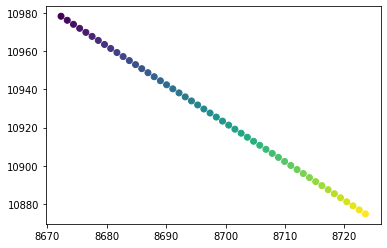

In [ ]:
# plot the projection of a 3d vertical line on the image plane
lon, lat = aoi['center']
h_min, h_max, h_step = -100, 150, 5
rpc = rpcm.rpc_from_geotiff(images[i])
p = np.asarray(projection_of_3d_vertical_line(rpc, lon, lat, h_min, h_max, h_step))
plt.figure()
plt.scatter(p[:, 0], p[:, 1], c=np.arange(h_min, h_max, h_step))

**Exercise 2.** Implement the `bounding_box_of_projected_aoi` function in the cell below. This function computes the pixel coordinates of the bounding box of an AOI (area of interest) in a GeoTIFF image. The AOI is defined in geographic coordinates, and the conversion to pixel coordinates uses the image RPC functions.

Its input arguments and outputs are described in the docstring.

To implement this function you may use:
* the `projection` method of the `rpcm.RPCModel` object
* `utils.bounding_box2D` to compute a horizontal/vertical rectangular bounding box

Remember that the `projection` function needs an altitude coordinate `z`, which **is not** contained in the `aoi` GeoJSON polygon. Thus the `bounding_box_of_projected_aoi` function expects an altitude argument `z`, which defaults to 0.

In [ ]:
def bounding_box_of_projected_aoi(rpc, aoi, z=0):
    """
    Return the x, y, w, h pixel bounding box of a projected AOI.

    Args:
        rpc (rpcm.RPCModel): RPC camera model
        aoi (geojson.Polygon): GeoJSON polygon representing the AOI
        z (float, optional): altitude of the AOI with respect to the WGS84 ellipsoid

    Return:
        x, y (ints): column and row of the top-left pixel of the bounding box
        w, h (ints): width and height of the bounding box, in pixels
    """
    z = 0 
    coord = [rpc.projection(lon, lat, z) for lon, lat in aoi['coordinates'][0]]
    box = np.round(utils.bounding_box2D(coord)).astype(int)
    return box


The function `crop_aoi` defined below uses your `bounding_box_of_projected_aoi` function to actually crop the AOI. It uses:
* `rpcm.rpc_from_geotiff` to read the RPC coefficients and get an `rpcm.RPCModel` object
* the `read()` method of `rasterio` datasets to do the crop by reading the requested subset of the input image

In [ ]:
def crop_aoi(geotiff, aoi, z=0, max_size=1e7):
    """
    Crop a geographic AOI in a georeferenced image using its RPC functions.

    Args:
        geotiff (str): path or url to the input GeoTIFF image file
        aoi (geojson.Polygon): GeoJSON polygon representing the AOI
        z (float, optional): base altitude with respect to WGS84 ellipsoid (0
            by default)
        max_size (int, optional): maximum allowed size for the crop, in pixels.
            If the area of the projected AOI bounding box exceeds this size,
            an exception is raised.

    Return:
        crop (array): numpy array containing the cropped image
        x, y (ints): pixel coordinates (column and row) of the top-left corner
            of the crop in the original image
    """
    x, y, w, h = bounding_box_of_projected_aoi(rpcm.rpc_from_geotiff(geotiff), aoi, z)
    if w*h > max_size:
        raise Exception("Crop too large. Please reduce your AOI.")
    with rasterio.open(geotiff, 'r') as src:
        crop = src.read(window=((y, y + h), (x, x + w)), boundless=True).squeeze()
    return crop, x, y

Let's use the AOI selected in the interactive map to get an image crop and display it!

The `srtm4.srtm4()` function can be used to get the altitude of the ground at coordinates `lon`, `lat`, in order to get an unbiased projection.

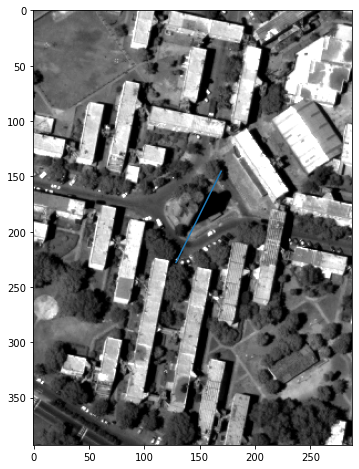

In [ ]:
# get the altitude of the center of the AOI
lon, lat  = aoi['center']
z = srtm4.srtm4(lon, lat)

# crop the selected AOI in image i
crop, x, y = crop_aoi(images[i], aoi, z)

# display the crop
plt.figure(figsize=(8, 8))
plt.imshow(utils.simple_equalization_8bit(crop), cmap='gray')

# plot the vertical line from the previous exercise
rpc = rpcm.rpc_from_geotiff(images[i])
p = np.asarray(projection_of_3d_vertical_line(rpc, lon, lat, z - 100, z + 100, 5))
plt.plot(p[:, 0] - x, p[:,  1] - y)

### Localization function

The _localization_ function is the inverse of the _projection_ function with respect to the image coordinates. It takes as input a triplet `x, y, z`, where `x` and `y` are pixel coordinates and `z` is the altitude of the corresponding 3D point above the WGS84 ellipsoid. It returns the longitude `lon` and latitude `lat` of the 3D point.

Some image providers, such as DigitalGlobe - the company that operates WorldView-3 - distribute their images with RPC coefficients for the _projection_ function only. In that cases, the _localization_ function can be evaluated by estimating iteratively the inverse of the _projection_ function. This is implemented in the `localization` method of the `rpcm.RPCModel` class.

The code below picks a point in the image, localizes this image point on the ground, projects back this 3D point on the image, then **computes the distance to the original image point**.

In [ ]:
# pick the projection of the center of the AOI on the image
lon, lat  = aoi['center']
z = srtm4.srtm4(lon, lat)
x, y = rpc.projection(lon, lat, z)

# localize this image point on the ground
lon, lat = rpc.localization(x, y, z)

# project back this point on the image
xx, yy = rpc.projection(lon, lat, z)

# compute the distance to the original point
print("Error of the inverse: {} pixels".format(np.linalg.norm([xx - x, yy - y])))

Error of the inverse: 2.679796630258511e-06 pixels


# C. Epipolar curves

**Exercise 3.** Implement the `epipolar_curve` function in the cell below. This function samples an epipolar curve of a pair of images by composing the _localization_ function of the first image with the _projection_ function of the second image.

In [ ]:
def epipolar_curve(rpc1, rpc2, x, y, h_min=-200, h_max=3000, h_step=10):
    """
    Sample the epipolar curve of image 2 associated to point (x, y) of image 1.

    Args:
        rpc1, rpc2 (rpcm.RPCModel): RPC camera models of the two images
        x, y (float): pixel coordinates of a point in image 1
        h_min, h_max (float): min, max altitudes defining the bounds of the epipolar curve
        h_step (float): step used to sample the epipolar curve

    Return:
        list of points in the second image given by their pixel coordinates
    """
    return [rpc2.projection(rpc1.localization(x, y, h)[0], rpc1.localization(x, y, h)[1], h) for h in np.arange(h_min, h_max, h_step)]

The code below calls your `epipolar_curve` function to plot the epipolar curve associated to the point `200, 200` of the first image. Observe that the epipolar curve is almost straight. Observe the relative pointing error.

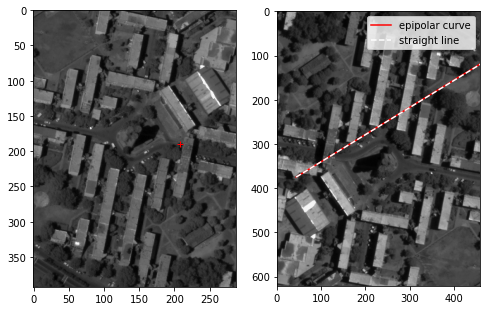

In [ ]:
# select two images
i, j = 0, 1

# get the altitude of the center of the AOI
lon, lat = aoi['center']
z = srtm4.srtm4(lon, lat)

# crop the two images
im1, x1, y1 = crop_aoi(images[i], aoi, z)
im2, x2, y2 = crop_aoi(images[j], aoi, z)

# select a point in the first image
x0, y0 = 208, 190

# compensate the crop offset of the first image
x, y = x0 + x1, y0 + y1

# read the RPC coefficients of the two images
rpc1 = rpcm.rpc_from_geotiff(images[i])
rpc2 = rpcm.rpc_from_geotiff(images[j])

# compute the epipolar curve
epi = epipolar_curve(rpc1, rpc2, x, y)

# compensate for the crop offset of the second image
p = np.array([(x - x2, y - y2) for x, y in epi])

# plot the epipolar curve on the second image
f, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].plot(x0, y0, 'r+')
ax[1].plot(p[:, 0], p[:, 1], 'r-', label="epipolar curve")
ax[1].plot(p[[0, -1], 0], p[[0, -1], 1], c="white", ls="--", alpha=1, label="straight line")
ax[1].legend()
ax[0].imshow(np.sqrt(im1), cmap='gray')
ax[1].imshow(np.sqrt(im2), cmap='gray')

# D. Affine approximation of the RPC camera model

Let $P: \mathbb{R}^3\longrightarrow \mathbb{R}^2$ be the _projection_ function. The first order Taylor approximation of $P$ around point $X_0$ is $P(X) = P(X_0) + \nabla P(X_0)(X - X_0)$, which can be rewritten as

$$
P(X) = \nabla P(X_0)X + T
$$

with $\nabla P(X_0)$ the jacobian matrix of size (2, 3) and $T = P(X_0) - \nabla P(X_0) X_0$ a vector of size 2. This can be rewritten as a linear operation by using homogeneous coordinates: with $X = (\lambda, \varphi, h, 1)$ the previous formula becomes $P(X) = AX$, where the (3, 4) matrix $A$ is defined by

$$
A = \begin{bmatrix}
\nabla P(X_0) & T\\
0 & 1
\end{bmatrix}
$$

$A$ is the _affine approximation_ of the RPC _projection_ function $P$ at point $X_0$. The `rpc_affine_approximation` function implemented in this exercise should compute and return $A$.

The gradient $\nabla P(X_0)$ can be computed in at least three different ways:
* formally, as $P$ is defined by an explicit formula involving elementary operations only,
* numerically, with a finite differences scheme as $P$ is very smooth,
* automatically, with [Automatic Differentiation (AD)](http://pythonhosted.org/ad/), using for example
the [jacobian](https://pythonhosted.org/ad/user_guide.html#access-to-more-than-one-derivative) function.

**Exercise 4.** Implement the `rpc_affine_approximation` function. This function computes an affine approximation of the RPC _projection_ function by using a first order Taylor approximation.

In [ ]:
def rpc_affine_approximation(rpc, p):
    """
    Compute the first order Taylor approximation of an RPC projection function.

    Args:
        rpc (rpcm.RPCModel): RPC camera model
        p (3-tuple of float): lon, lat, z coordinates

    Return:
        array of shape (3, 4) representing the affine camera matrix equal to the
        first order Taylor approximation of the RPC projection function at point p.
    """
    lon, lat = aoi['center']
    z = srtm4.srtm4(lon, lat)
    p = lon, lat, z
    p = ad.adnumber(p)
    q = rpc.projection(*p)
    J = ad.jacobian(q, p)
    T = q - np.dot(J,p)
    A = np.zeros((3,4))
    A[:2,:3] = J
    A[:2, 3] = T
    A[2,3] = 1
    return A


The code below calls your `rpc_affine_approximation` function to compute the affine camera matrix approximating the RPC _projection_ function around the center $X_0$ of the area selected in the map. Then it evaluates the approximation error away from the center.

In [ ]:
# get the altitude of the center of the AOI
lon, lat = aoi['center']
z = srtm4.srtm4(lon, lat)

# compute the affine projection matrix
A = rpc_affine_approximation(rpc, (lon, lat, z))

# approximation error at the center
err = np.linalg.norm((A @ [lon, lat, z, 1])[:2] - np.array(rpc.projection(lon, lat, z)))
print("Error at the center: {} pixels".format(err))

# compute the projection in the image
x, y = rpc.projection(lon, lat, z)
dx, dy = 500, 500
lon1, lat1 = rpc.localization(x + dx, y + dy, z)

# approximation error at center + (dx, dy)
err = np.linalg.norm((A @ [lon1, lat1, z, 1])[:2] - np.array(rpc.projection(lon1, lat1, z)))
print("Error at {}, {} pixels from the center: {} pixels".format(dx, dy, err))

Error at the center: 4.2823198512086415e-10 pixels
Error at 500, 500 pixels from the center: 0.09616198610878374 pixels


# E. Affine rectification

### Fundamental matrix

In the affine camera model, the epipolar lines are bundles of parallel lines.  These bundles are described by a $3\times 3$ _fundamental matrix_ $F$, such that the epipolar line of a point $\bf x$ in the first image has the equation ${\bf y}^T F{\bf x}=0$ for ${\bf y}$ in the second image.  Since all these lines are parallel, the matrix $F$ has the form $F=\begin{bmatrix}\begin{smallmatrix}0 & 0 & a \\ 0 & 0 & b \\ c & d & e \end{smallmatrix}\end{bmatrix}$.  The coefficients of $F$ are found from the two projection matrices $A$ and $B$ by imposing the homogeneous epipolarity constraints $k_1{\bf x}=A{\bf X}$ and $k_2{\bf y}=B{\bf X}$ of a generic point $\bf X$ in space. This is a $6\times 6$ singular system of equations whose solution can be computed explicitly
<!-- (see e.g. Formulas 8.1. and 16.3 from Hartley-Zissserman). -->
(see e.g. formula 17.3 (p. 412) from Hartley-Zisserman 2nd, edition).

<!--
The first formula uses the right Moore-Penrose pseudo-inverse $A^+=A^T(AA^T)^{-1}$ that has the property that $AA^+=I$ :


$$
F=[{\bf e}]_\times BA^+
$$
-->

This formula expresses directly each entry of $F$ in terms of determinants computed from the entries of $A$ and $B$ :


$$
F_{ji} = (-1)^{i+j}\mathrm{det}\ \begin{bmatrix}\sim\mathbf{a}^i \\ \sim\mathbf{b}^j\end{bmatrix}
$$

where $\sim {\bf a}^i$ denotes the matrix obtained from $A$ by omitting the row ${\bf a}^i$. Thus, for example, the coefficient $F_{13}$ (first row, third column) is equal to the determinant of the $4\times 4$ matrix

$$
\begin{bmatrix}{\bf a}^1\\ {\bf a}^2 \\ {\bf b }^2\\ {\bf b}^3\end{bmatrix}
$$

**Exercise 5.** Implement the `affine_fundamental_matrix` function. This function computes the affine fundamental matrix from two affine camera matrices.

In [ ]:
def affine_fundamental_matrix(a, b):
    """
    Compute the affine fundamental matrix from two affine camera matrices.

    Args:
        a, b: arrays of shape (3, 4) representing the input camera matrices.

    Return:
        array of shape (3, 3) representing the affine fundamental matrix computed
        with the formula 17.3 (p. 412) from Hartley & Zisserman book (2nd ed.).
    """
    F = np.zeros((3,3))
    for i in range(3):
      for j in range(3):
        M = np.row_stack((a[:i],a[i+1:], b[:j], b[j+1:]))
        F[j,i] = (-1)**(i+j) * np.linalg.det(M)
    return F

The code below calls your `affine_fundamental_matrix` function to compute the affine fundamental matrix associated to our two images. Check that the 2, 2 top-left block of the matrix is zero.

In [ ]:
lon, lat = aoi['center']
z = srtm4.srtm4(lon, lat)

# select two images and read their RPC coefficients
i, j = 38, 39
rpc1 = rpcm.rpc_from_geotiff(images[i])
rpc2 = rpcm.rpc_from_geotiff(images[j])

A = rpc_affine_approximation(rpc1, (lon, lat, z))   # affine projection matrix for first image
B = rpc_affine_approximation(rpc2, (lon, lat, z))   # affine projection matrix for second image

F = affine_fundamental_matrix(A, B)
F

array([[ 0.00000000e+00, -0.00000000e+00, -3.82236157e+10],
       [-0.00000000e+00,  0.00000000e+00, -9.23166453e+09],
       [ 3.89003876e+10,  9.45310509e+09, -3.17144319e+12]])

The code below plots the epipolar lines bundles corresponding to `F`. Check that there is a one to one matching between the epipolar lines overlaid on the two images. Matching lines have the same colour, and should pass (roughly, i.e. up to a few pixels of _pointing error_) through the same scene points. Notice that the two images may be rotated with respect to each other. In that case, matching epipolar lines may be more difficult to see.


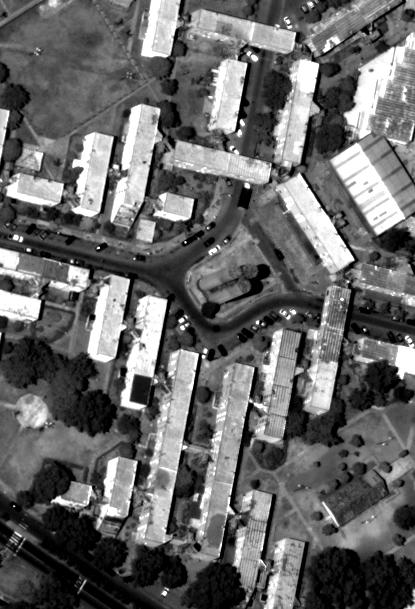
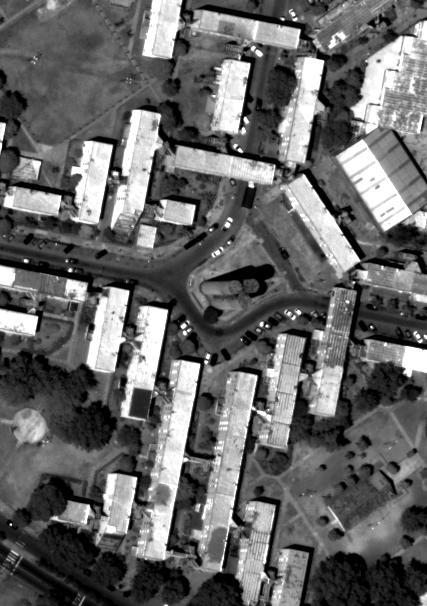

In [ ]:
# crop the two images
im1, x1, y1 = crop_aoi(images[i], aoi, z)
im2, x2, y2 = crop_aoi(images[j], aoi, z)

# crops bounding boxes
h1, w1 = im1.shape
h2, w2 = im2.shape
bbx1 = x1, y1, w1, h1
bbx2 = x2, y2, w2, h2

# plot epipolar lines
svg1, svg2 = rectification.plot_epipolar_lines(F, bbx1, bbx2)

vistools.display_gallery([utils.simple_equalization_8bit(im1),
                          utils.simple_equalization_8bit(im2)],
                         svg_overlays=[svg1, svg2])

### Rectifying similarities

A similarity is a planar transformation that preserve shapes. It can be made of translations, rotations and scalings.

If the affine fundamental matrix $F$ is given by
$$
F = \begin{bmatrix}
0 & 0 & a\\
0 & 0 & b\\
c & d & e
\end{bmatrix}
$$
then two similarities $S_1$ and $S_2$ that rectify the images are given by

$$
\texttt{S}_1 =
\left[
 \begin{array}{c|c}
  z\texttt{R}_1 &
 \begin{array}{c}
     0\\ t
 \end{array}\\
 \hline
 \begin{array}{cc}
  0 & 0
  \end{array} & 1
\end{array}
\right]
\qquad\qquad
\texttt{S}_2 =
\left[
 \begin{array}{c|c}
  \frac{1}{z}\texttt{R}_2 &
 \begin{array}{c}
     0\\ -t
 \end{array}\\
 \hline
 \begin{array}{cc}
  0 & 0
  \end{array} & 1
\end{array}
\right]
$$

where $z = \sqrt{\frac{r}{s}}$, $t = \frac{e}{2\sqrt{rs}}$ with $r=\sqrt{c^2+d^2}$, $s=\sqrt{a^2+b^2}$ and the two rotations $R_1$ and $R_2$ are given by

$$
 \texttt{R}_1 = \frac{1}{\sqrt{c^2 + d^2}} \begin{bmatrix}d & -c\\ c & d\end{bmatrix}
\qquad\qquad
  \texttt{R}_2 = \frac{1}{\sqrt{a^2 + b^2}} \begin{bmatrix}-b & a\\ -a & -b\end{bmatrix}
$$

**Exercise 6.** Implement the `rectifying_similarities` function. This function computes two similarities that transform the epipolar lines in a set of matching horizontal lines. The operation of resampling a pair of images such that the epipolar lines become horizontal and aligned is called _stereo rectification_ or _epipolar resampling_.

In [ ]:
def rectifying_similarities(F, debug=False):
    """
    Computes two similarities from an affine fundamental matrix.

    Args:
        F: 3x3 numpy array representing the input fundamental matrix
        debug (optional, default is False): boolean flag to activate verbose
            mode

    Returns:
        S, S': two similarities such that, when used to resample the two images
            related by the fundamental matrix, the resampled images are
            stereo-rectified.
    """

    a, b, c, d, e = F[0,2], F[1,2], F[2,0], F[2,1], F[2,2]
    r = np.sqrt(c**2 + d**2)
    s = np.sqrt(a**2 + b**2)
    z = np.sqrt(r/s)
    t = np.exp(1)/(2*np.sqrt(r*s))
    S1 = np.array([[z*d/r, -z*c/r, 0], [z*c/r, z*d/r, t], [0,0,1]])
    S2 = np.array([[-b/(s*z), a/(s*z), 0], [-a/(s*z), -b/(s*z), -t], [0,0,1]])
    return S1, S2

### Putting all together

The function `rectifying_affine_transforms` below uses the three functions

* `rpc_affine_approximation`,
* `affine_fundamental_matrix` and
* `rectifying_similarities`

to compute two rectifying similarities $\texttt{S}_1$ and $\texttt{S}_2$ for two input images on a given AOI.

Then it composes them with two translations that crop the rectified images on the AOI bounding box, and computes the minimal crop size needed to ensure that the whole AOI is included in both rectified image crops.

Optionally, it corrects $\texttt{S}_2$ with a planar affine transform such that $\texttt{S}_2\texttt{P}_2$ and $\texttt{S}_1\texttt{P}_1$ both map the corners of the AOI to the same pixel coordinates, so that the rectified image crops are registered. This will be implemented in the last exercise.

In [ ]:
def rectifying_affine_transforms(rpc1, rpc2, aoi, z=0, register_ground=True):
    """
    Compute two affine transforms that rectify two images over a given AOI.

    Args:
        rpc1, rpc2 (rpcm.RPCModel): two RPC camera models
        aoi (geojson.Polygon): area of interest

    Return:
        S1, S2 (2D arrays): two numpy arrays of shapes (3, 3) representing the
            rectifying affine transforms in homogeneous coordinates
        w, h (ints): minimal width and height of the rectified image crops
            needed to cover the AOI in both images
        P1, P2 (2D arrays): two numpy arrays of shapes (3, 3) representing the
            affine camera matrices used to approximate the rpc camera models
    """
    # center of the AOI
    lons, lats = np.asarray(aoi['coordinates'][0][:4]).T
    lon, lat = np.mean([lons, lats], axis=1)

    # affine projection matrices that approximate the rpc models around the
    # center of the AOI
    P1 = rpc_affine_approximation(rpc1, (lon, lat, z))
    P2 = rpc_affine_approximation(rpc2, (lon, lat, z))

    # affine fundamental matrix associated to the two images
    F = affine_fundamental_matrix(P1, P2)

    # rectifying similarities
    S1, S2 = rectifying_similarities(F)

    if register_ground:
        S1, S2 = ground_registration(aoi, z, P1, P2, S1, S2)

    # aoi bounding boxes in the rectified images
    x1, y1, w1, h1 = utils.bounding_box_of_projected_aoi(rpc1, aoi, z=z,
                                                         homography=S1)
    x2, y2, w2, h2 = utils.bounding_box_of_projected_aoi(rpc2, aoi, z=z,
                                                         homography=S2)
    S1 = utils.matrix_translation(-x1, -min(y1, y2)) @ S1
    S2 = utils.matrix_translation(-x2, -min(y1, y2)) @ S2

    w = int(round(max(w1, w2)))
    h = int(round(max(y1 + h1, y2 + h2) - min(y1, y2)))
    return S1, S2, w, h, P1, P2

# F.  Rectification in practice

The function `rectifying_affine_transforms` in the previous section only computes the transformations needed to rectify the images. The function `rectify_aoi` in the code cell below produces the resampled rectified image crops that are then displayed in a gallery. Flip between the images to see how the buildings move!

In [ ]:
def rectify_aoi(file1, file2, aoi, z=None, correct_pointing=True,
                register_ground=True, debug=False):
    """
    Args:
        file1, file2 (strings): file paths or urls of two satellite images
        aoi (geojson.Polygon): area of interest
        z (float, optional): base altitude with respect to WGS84 ellipsoid. If
            None, z is retrieved from srtm.

    Returns:
        rect1, rect2: numpy arrays with the images
        S1, S2: transformation matrices from the coordinate system of the original images
        disp_min, disp_max: horizontal disparity range
        P1, P2: affine rpc approximations of the two images computed during the rectification
    """
    # read the RPC coefficients
    rpc1 = rpcm.rpc_from_geotiff(file1)
    rpc2 = rpcm.rpc_from_geotiff(file2)

    # get the altitude of the center of the AOI
    if z is None:
        lon, lat = np.mean(aoi['coordinates'][0][:4], axis=0)
        z = srtm4.srtm4(lon, lat)

    # compute rectifying affine transforms
    S1, S2, w, h, P1, P2 = rectifying_affine_transforms(rpc1, rpc2, aoi, z, register_ground)

    # compute SIFT keypoint matches (needed to estimate the disparity range)
    q1, q2 = rectification.sift_roi(file1, file2, aoi, z)

    # correct pointing error with the SIFT keypoint matches (optional)
    if correct_pointing:
        S1, S2 = pointing_error_correction(S1, S2, q1, q2)

    # rectify the crops
    rect1 = rectification.affine_crop(file1, S1, w, h)
    rect2 = rectification.affine_crop(file2, S2, w, h)

    # transform the matches to the domain of the rectified images
    q1 = utils.points_apply_homography(S1, q1)
    q2 = utils.points_apply_homography(S2, q2)

    # disparity range bounds
    kpts_disps = (q2 - q1)[:, 0]
    disp_min = np.percentile(kpts_disps, 5)
    disp_max = np.percentile(kpts_disps, 100 - 5)

    if debug:  # matches visualisation
        import cv2
        kp1 = [cv2.KeyPoint(x, y, 1, 0)  for x, y in q1]
        kp2 = [cv2.KeyPoint(x, y, 1, 0)  for x, y in q2]
        matches = [[cv2.DMatch(i, i, 0, 0)] for i in range(len(q1))]
        plt.figure()
        plt.imshow(cv2.drawMatchesKnn(utils.simple_equalization_8bit(rect1), kp1,
                                      utils.simple_equalization_8bit(rect2), kp2,
                                      matches, None, flags=2))
        plt.show()

    return rect1, rect2, S1, S2, disp_min, disp_max, P1, P2


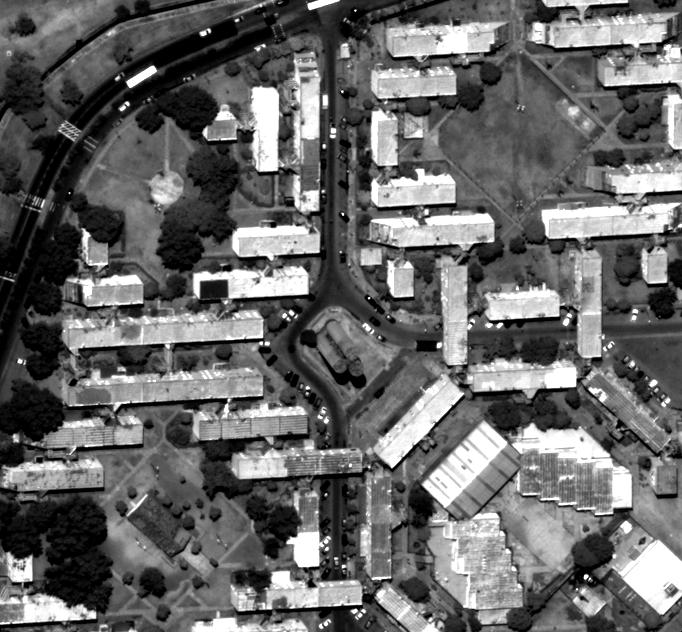
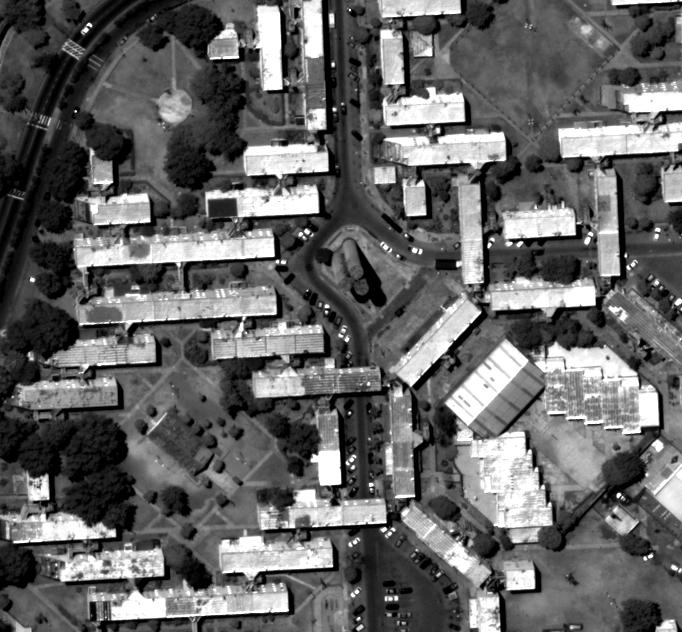

In [ ]:
z = srtm4.srtm4(*aoi['center'])
rect1, rect2, S1, S2, disp_min, disp_max, P1, P2 = rectify_aoi(images[i],
                                                               images[j],
                                                               aoi, z=z,
                                                               correct_pointing=False,
                                                               register_ground=False)

# display the rectified crops
vistools.display_gallery([utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)])

### Pointing error

Inspect the two images by hovering the mouse over the numbers `0` and `1` on the left side of the image. Go back and forth to flip between the images. What do you notice?

You should see only horizontal displacements, but the images are not "vertically aligned" (at least not perfectly): the rectification has failed! This is due to the _relative pointing error_. In the IARPA dataset, the relative pointing error is particularly visible in image pairs (0, 5) and (0, 11). In other image pairs, such as (27, 28), the error is very small and almost invisible.

Using image matches, such as SIFT keypoint matches, one can estimate a vertical shift that corrects the relative pointing error. The code cell below uses the `debug` argument of the `rectify_aoi` function to show SIFT keypoint matches.

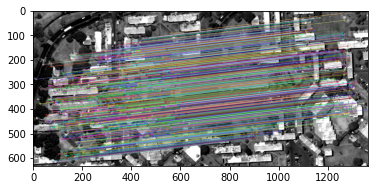

In [ ]:
z = srtm4.srtm4(*aoi['center'])
_ = rectify_aoi(images[i], images[j], aoi, z=z, correct_pointing=False, register_ground=False, debug=True)

**Exercise 7.** Complete the implementation of the function `pointing_error_correction`. This function uses a list of keypoint matches to estimate the vertical parallax remaining after rectification, and corrects the rectifying transforms $\texttt{S}_1$ and $\texttt{S}_2$ accordingly with vertical shifts.

In [ ]:
def pointing_error_correction(S1, S2, q1, q2):
    """
    Correct rectifying similarities for the pointing error.

    Args:
        S1, S2 (np.array): two 3x3 matrices representing the rectifying similarities
        q1, q2 (lists): two lists of matching keypoints

    Returns:
        two 3x3 matrices representing the corrected rectifying similarities
    """
    # transform the matches to the domain of the rectified images
    q1 = utils.points_apply_homography(S1, q1)
    q2 = utils.points_apply_homography(S2, q2)

    # CODE HERE: insert a few lines to correct the vertical shift
    shift = np.median(q2-q1,axis=0)[1]

    S1[1,2] += shift/2
    S2[1,2] += -shift/2

    return S1, S2

The next cell re-runs the `rectify_aoi` function with the option `correct_pointing=True` which calls your `pointing_error_correction` function to correct the pointing error shift. Now you should observe only horizontal displacements!


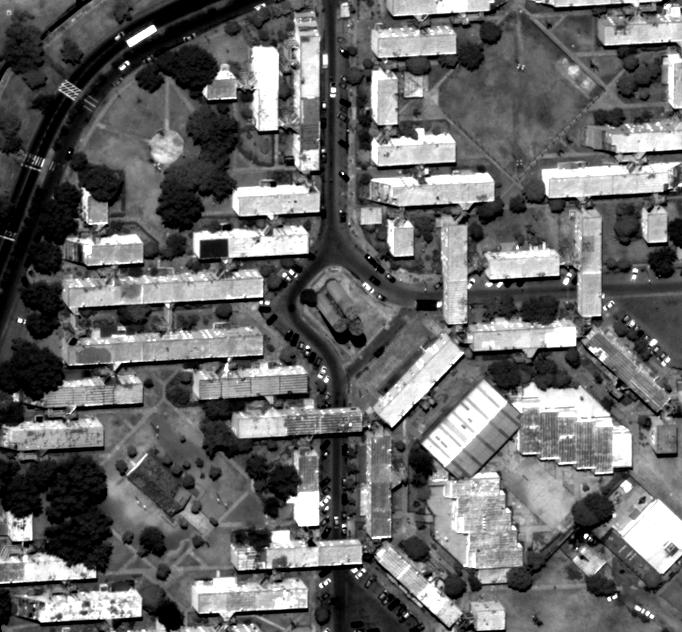
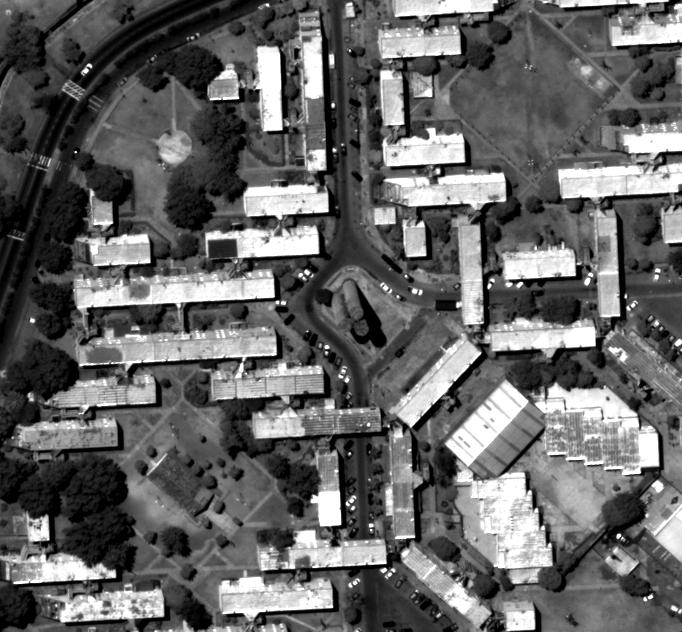

In [ ]:
z = srtm4.srtm4(*aoi['center'])
rect1, rect2, S1, S2, disp_min, disp_max, P1, P2 = rectify_aoi(images[i],
                                                               images[j],
                                                               aoi, z=z,
                                                               correct_pointing=True,
                                                               register_ground=False)

# display the rectified crops
vistools.display_gallery([utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)])

### Ground registration

Now the rectification should be correct: there shouldn't be any vertical displacement.

However, how large are the horizontal displacements? How much does the ground move? How much do the roofs of the buildings move? Knowing the camera models $\texttt{P}_1$, $\texttt{P}_2$ and the altitude of the ground, we should be able to compose $\texttt{S}_2$ with a planar affine transform such that both $\texttt{S}_2\texttt{P}_2$ and $\texttt{S}_1\texttt{P}_1$ map the corners of the AOI to the same pixel coordinates, so that the rectified image crops are registered.

**Exercise 8.** Implement the `ground_registration` function in the cell below. You may use the `rectification.affine_transformation` function to estimate a planar affine transformation that maps a list of 2D points onto another.

In [ ]:
def ground_registration(aoi, z, P1, P2, S1, S2):
    """
    Correct rectifying similarities with affine transforms to register the ground.

    Args:
        aoi (geojson.Polygon): area of interest
        z (float): altitude of the ground
        P1, P2 (2D arrays): two numpy arrays of shapes (3, 3) representing two
            affine camera matrices
        S1, S2 (2D arrays): two numpy arrays of shapes (3, 3) representing two
            rectifying similarities in homogeneous coordinates
    """
    lons, lats = np.asarray(aoi['coordinates'][0][:4]).T
    q1 = S1 @ P1 @ [lons, lats, [z, z, z, z], [1, 1, 1, 1]]
    q2 = S2 @ P2 @ [lons, lats, [z, z, z, z], [1, 1, 1, 1]]
    S2 = rectification.affine_transformation(q2[:2].T, q1[:2].T) @ S2
    return S1, S2

The next cell re-runs the `rectify_aoi` function with the option `register_ground=True` which calls your `ground_registration` function to reduce the horizontal displacements between the two rectified images. Now you should see almost only the buildings flipping!

If the ground still moves, it could be that the altitude value `z` used to estimate the registering affine transformation is not perfectly accurate. Try to increase or decrease it manually to find the best value that makes the ground perfectly registered.


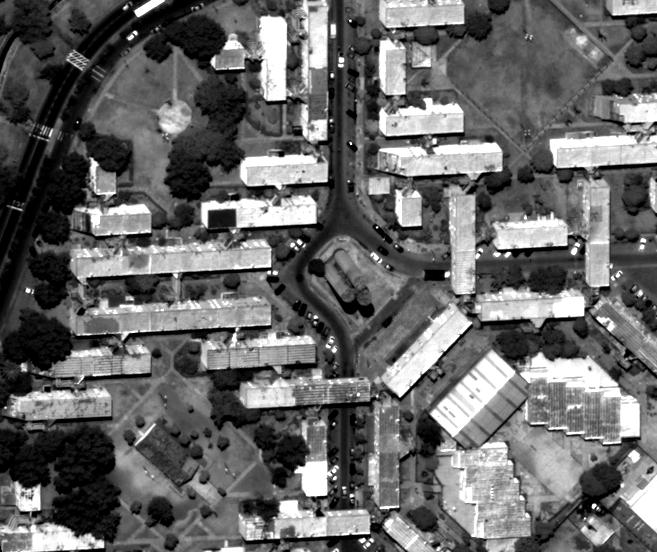
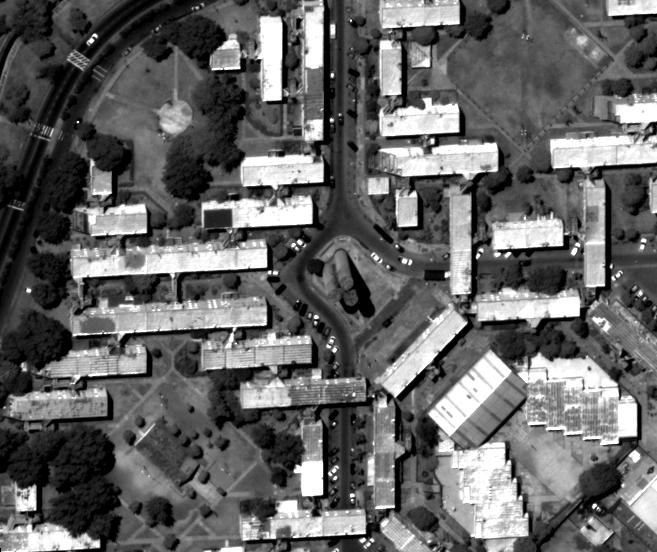

In [ ]:
i, j = 38, 39
z = srtm4.srtm4(*aoi['center']) - 12
rect1, rect2, S1, S2, disp_min, disp_max, P1, P2 = rectify_aoi(images[i],
                                                               images[j],
                                                               aoi, z=z,
                                                               correct_pointing=True,
                                                               register_ground=True)

# display the rectified crops
vistools.display_gallery([utils.simple_equalization_8bit(rect1),
                          utils.simple_equalization_8bit(rect2)])

**Corrected stereo-rectified pairs of image crops will be used as inputs for the practical session on stereo matching algorithms.**

---------------------------
[//]: # (© 2018-2020 Carlo de Franchis, Gabriele Facciolo, Enric Meinhardt)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018-2020 Carlo de Franchis, Gabriele Facciolo, Enric Meinhardt. All rights reserved.</div>)